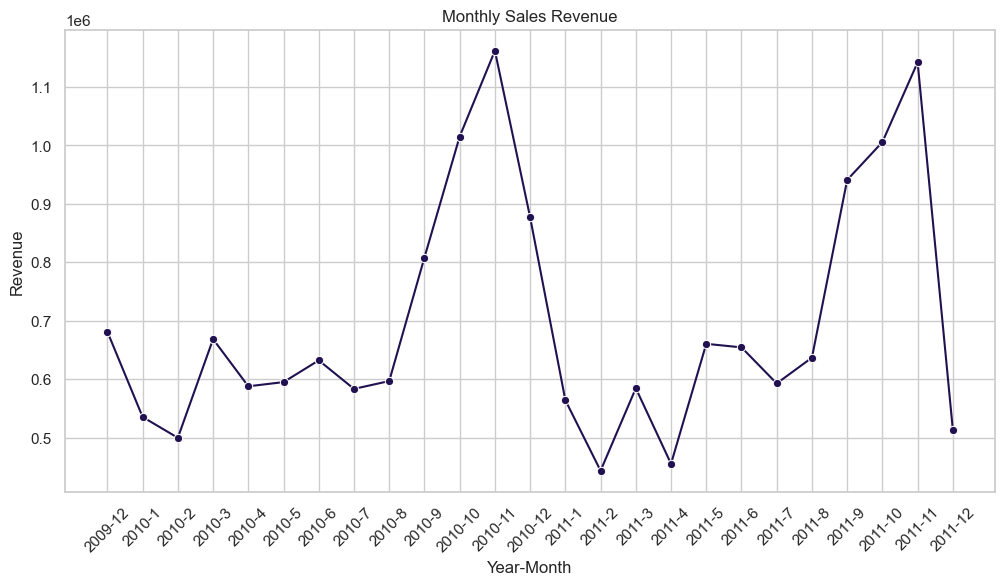

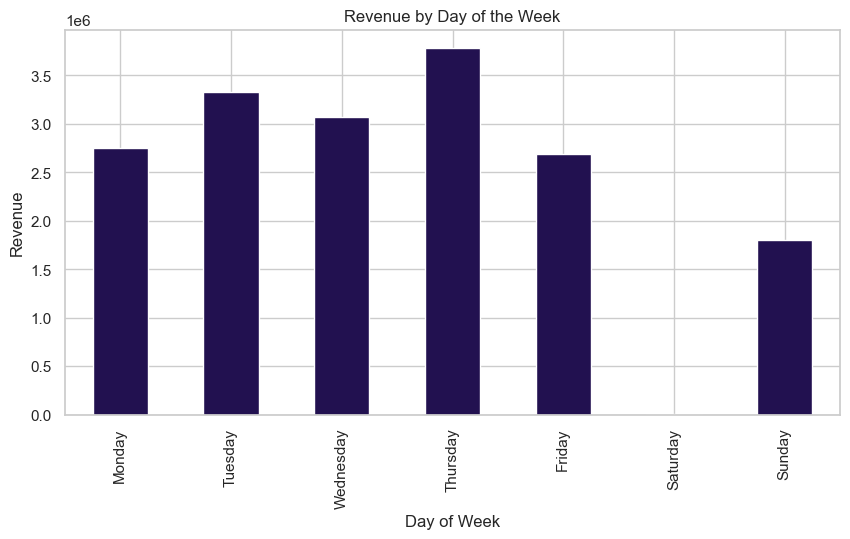

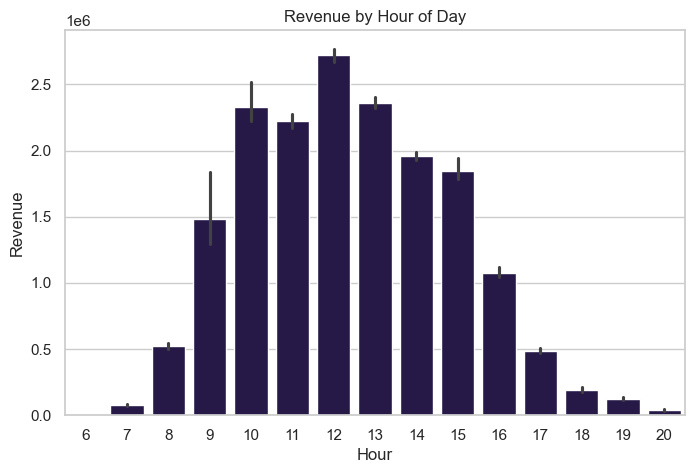

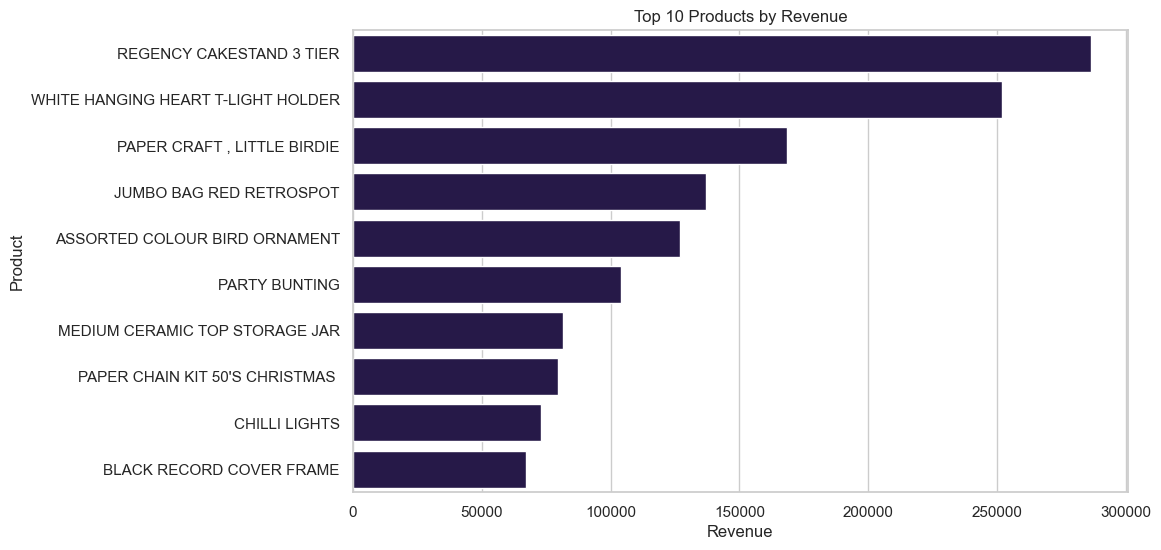

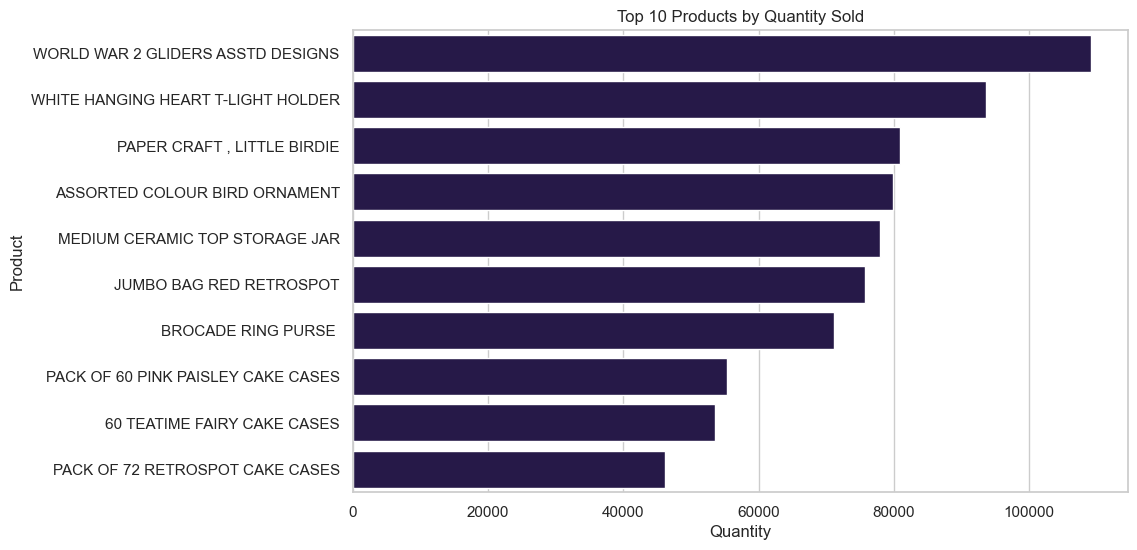

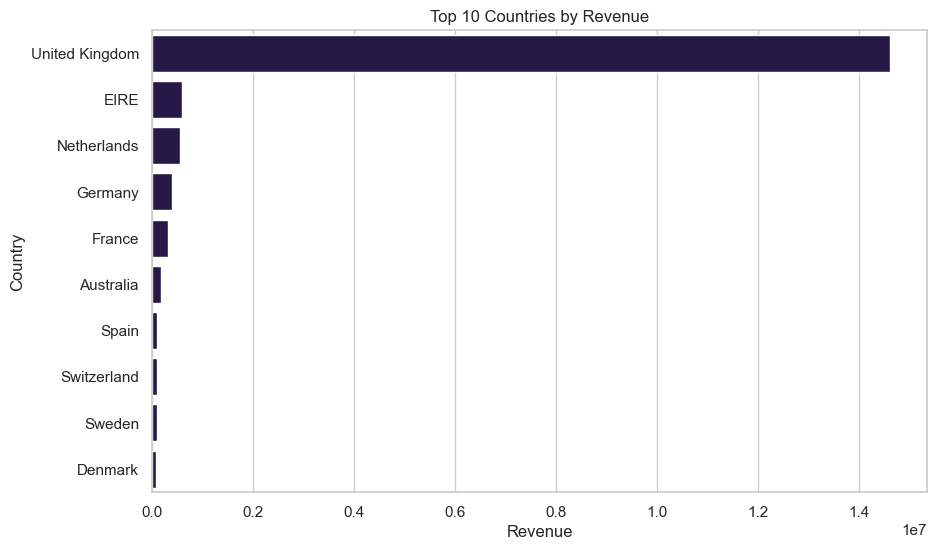

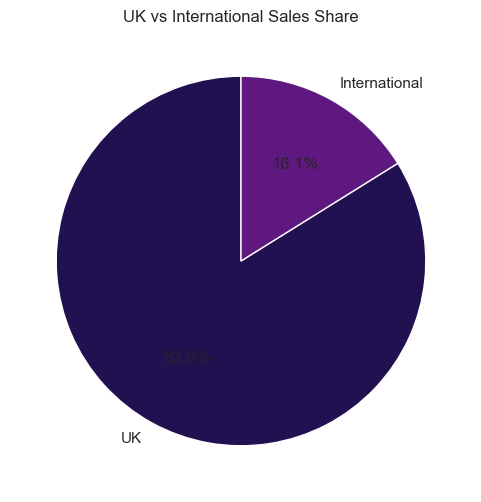

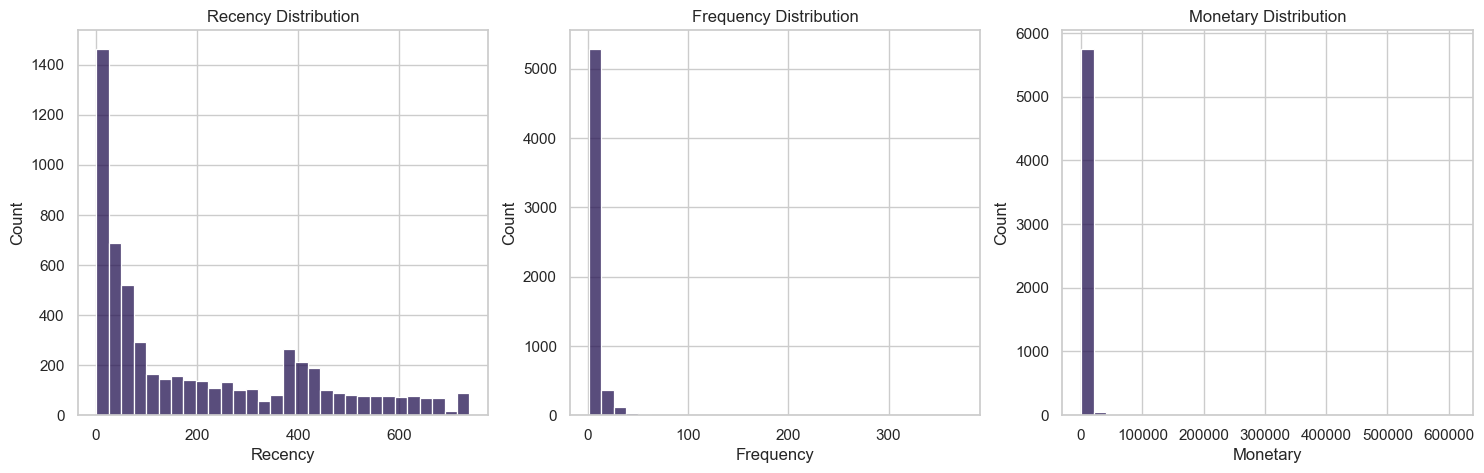

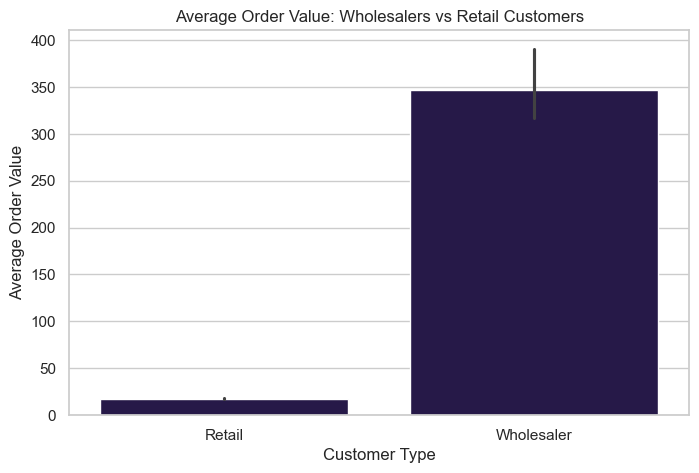

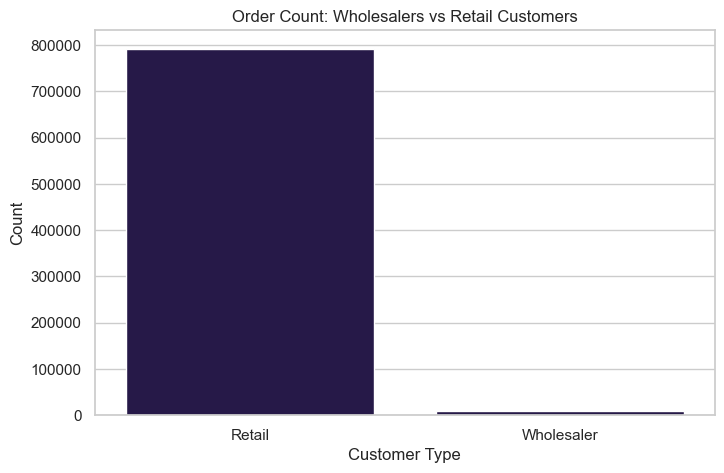

In [4]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests


# Load the dataset
df = pd.read_csv('online_retail.csv')

# Remove missing customers
df = df.dropna(subset=['Customer ID'])

# Convert 'Customer Id' to integer
df['Customer ID'] = df['Customer ID'].astype(int)

# Remove canceled orders
df = df[~df['Invoice'].str.startswith('C')]

# Remove rows where item price was '0'
df = df[df['Price'] > 0]

# Remove non-product stock codes
# List of non-product codes
non_product_codes = ['POST', 'DOT', 'ADJUST', 'C2', 'M', 'BANK CHARGES']

# Keep only rows where StockCode is NOT in the list
df = df[~df['StockCode'].isin(non_product_codes)]

# Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract Year, Month, DayOfWeek, Hour:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Save the cleaned dataset to a new CSV file
df.to_csv('online_retail_cleaned.csv', index=False)

# Visualization style
sns.set_theme(style="whitegrid", palette="magma")

# 2. Sales Performance & Seasonality

# Monthly revenue trends
monthly_sales = df.groupby(["Year", "Month"])["TotalPrice"].sum().reset_index()
monthly_sales["YearMonth"] = monthly_sales["Year"].astype(str) + "-" + monthly_sales["Month"].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x="YearMonth", y="TotalPrice", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Revenue")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.show()

# Day of week sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Weekday'] = df['InvoiceDate'].dt.day_name()  
weekday_sales = df.groupby('Weekday')['TotalPrice'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(10,5))
weekday_sales.plot(kind='bar')
plt.title("Revenue by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.show()

# Hourly sales
plt.figure(figsize=(8,5))
sns.barplot(x="Hour", y="TotalPrice", data=df, estimator=sum)
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.show()

# 3. Product Portfolio Analysis

# Top 10 products by revenue
top_products_revenue = df.groupby("Description")["TotalPrice"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# Top 10 products by quantity
top_products_quantity = df.groupby("Description")["Quantity"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Quantity")
plt.ylabel("Product")
plt.show()

# 4. Geographic Footprint

# ---- Create Revenue column ----
df["Revenue"] = df["Quantity"] * df["Price"]

# ---- Group by Country and sum revenue ----
country_sales = df.groupby("Country", as_index=False)["Revenue"].sum()

# Top 10 countries by revenue
country_sales = df.groupby("Country")["TotalPrice"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()

# UK vs International sales
uk_sales = df[df["Country"]=="United Kingdom"]["TotalPrice"].sum()
intl_sales = df[df["Country"]!="United Kingdom"]["TotalPrice"].sum()

plt.figure(figsize=(6,6))
plt.pie([uk_sales, intl_sales], labels=["UK", "International"], autopct="%.1f%%", startangle=90)
plt.title("UK vs International Sales Share")
plt.show()


# 5. Customer Segmentation (RFM)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalPrice": "sum"
}).rename(columns={"InvoiceDate":"Recency","Invoice":"Frequency","TotalPrice":"Monetary"})

# RFM distributions
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.show()

# 6. Wholesale vs Retail Analysis

# Define customer type
df["CustomerType"] = np.where(df["Quantity"]>100, "Wholesaler", "Retail")

# Average order value comparison
plt.figure(figsize=(8,5))
sns.barplot(x="CustomerType", y="TotalPrice", data=df, estimator=np.mean)
plt.title("Average Order Value: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Average Order Value")
plt.show()

# Order count comparison
plt.figure(figsize=(8,5))
sns.countplot(x="CustomerType", data=df)
plt.title("Order Count: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.show()





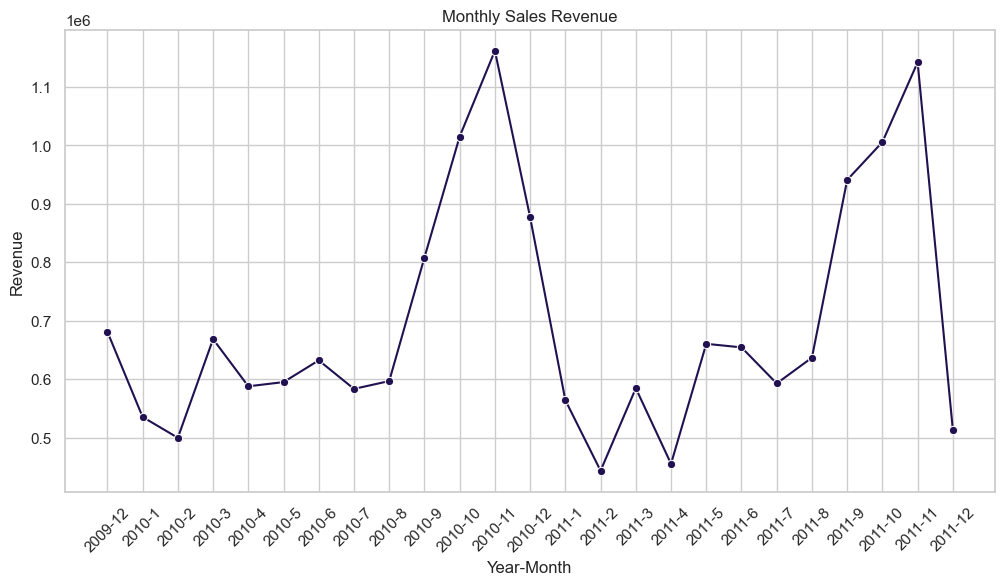

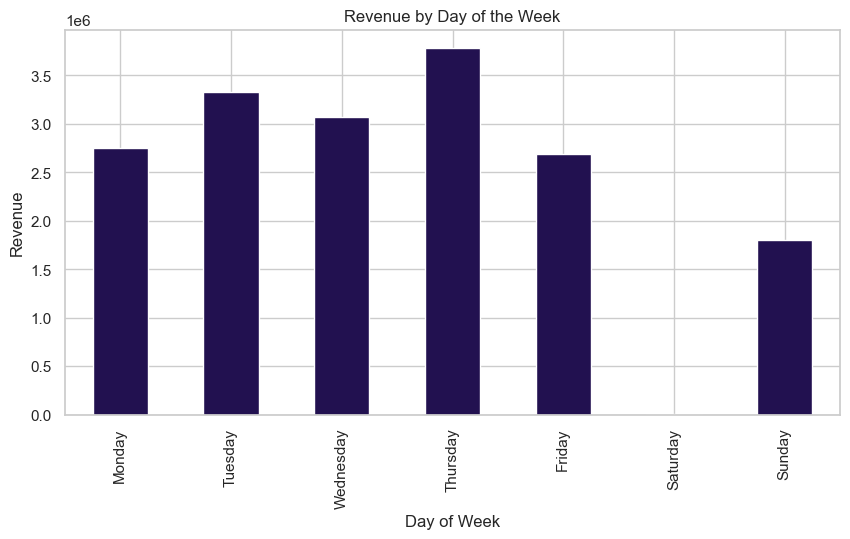

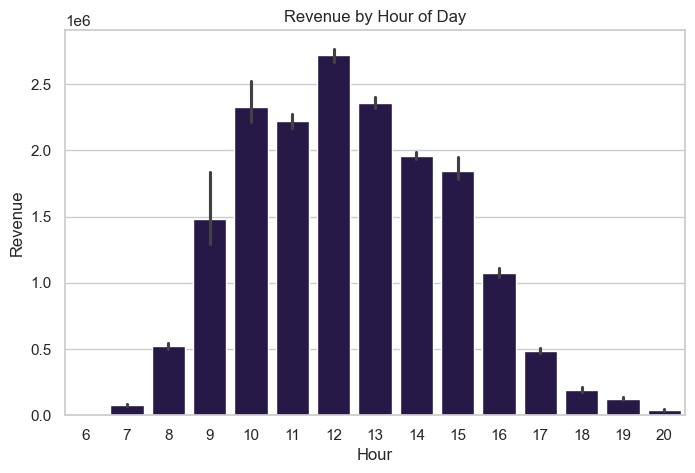

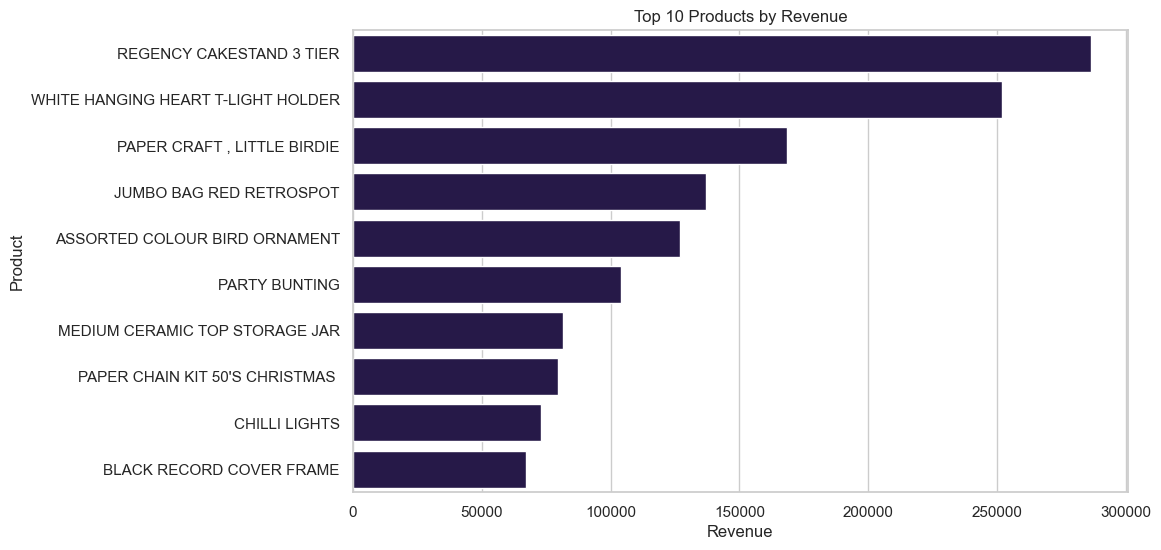

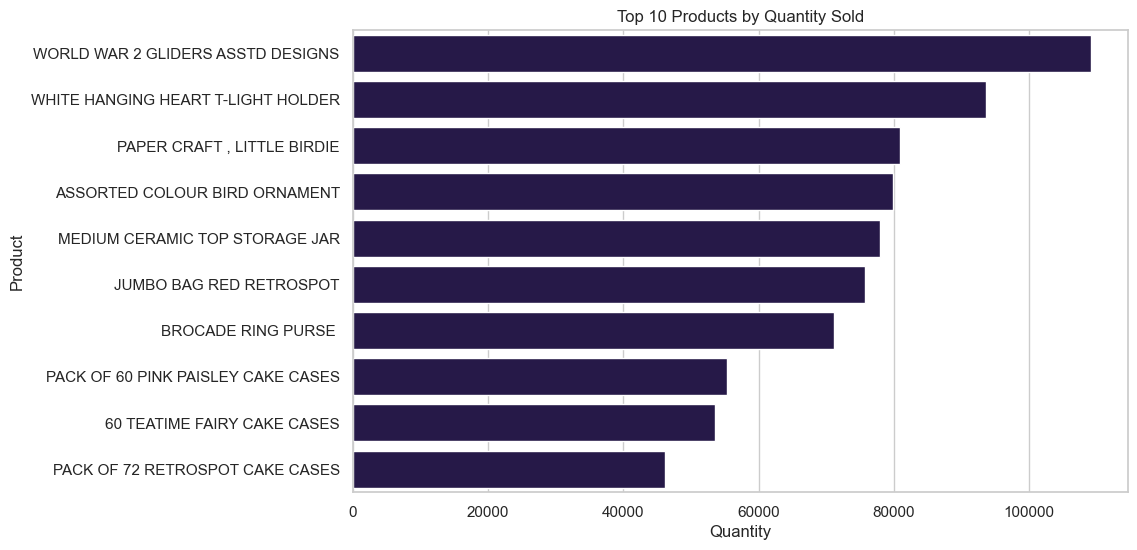

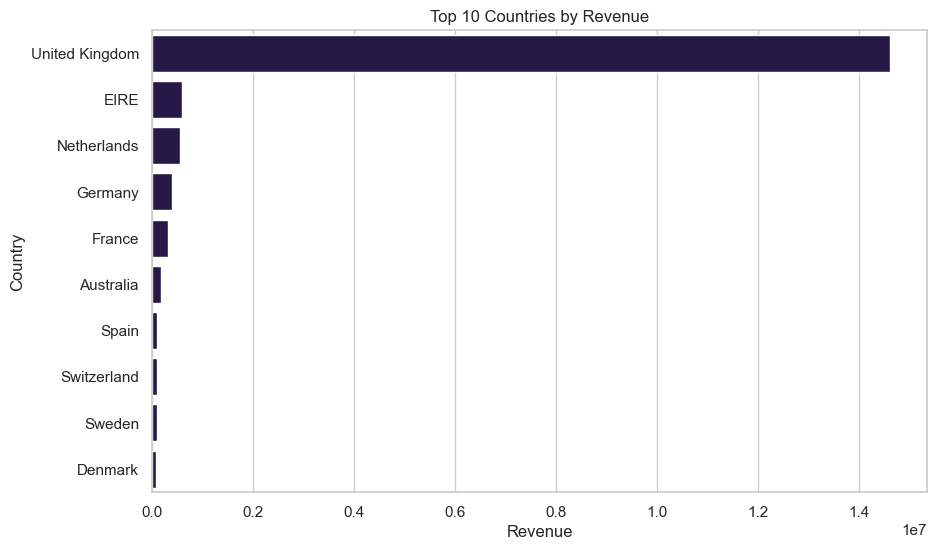

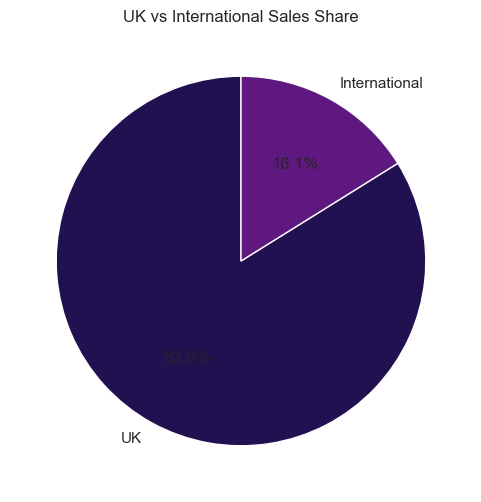

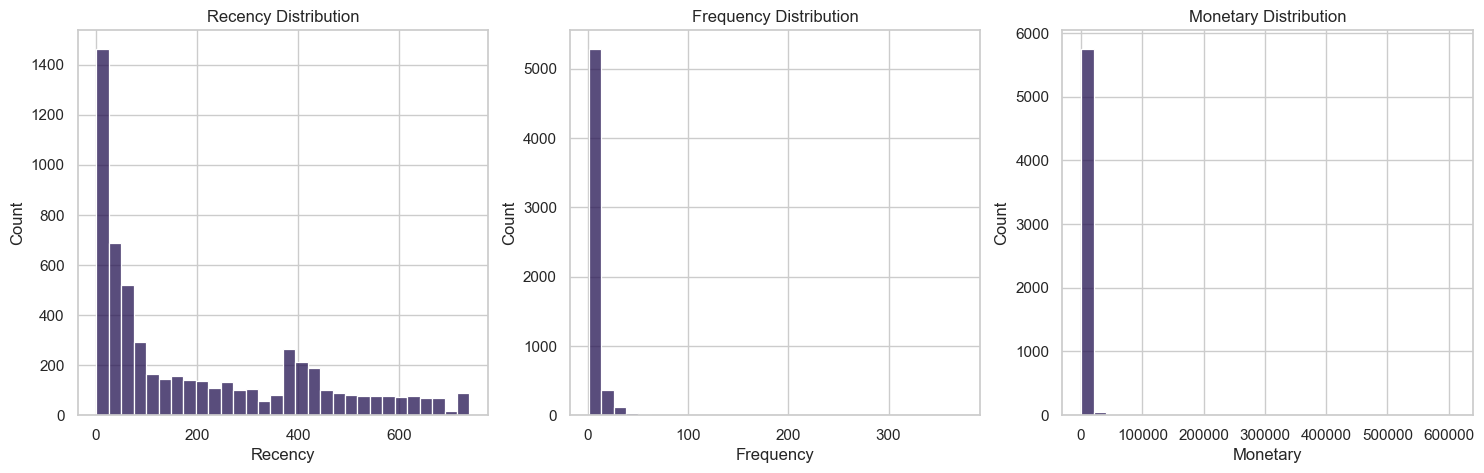

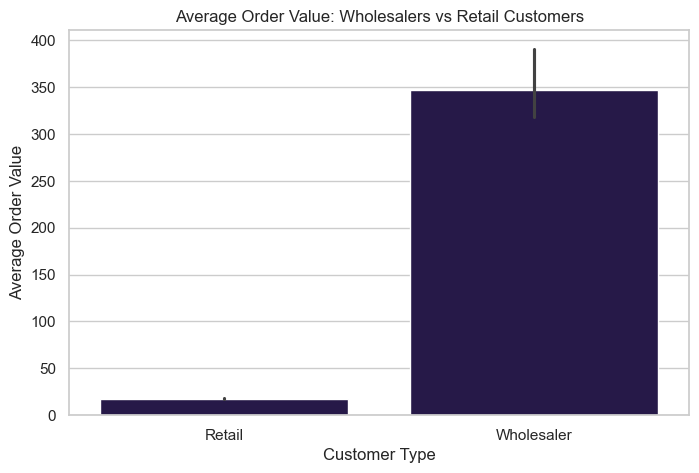

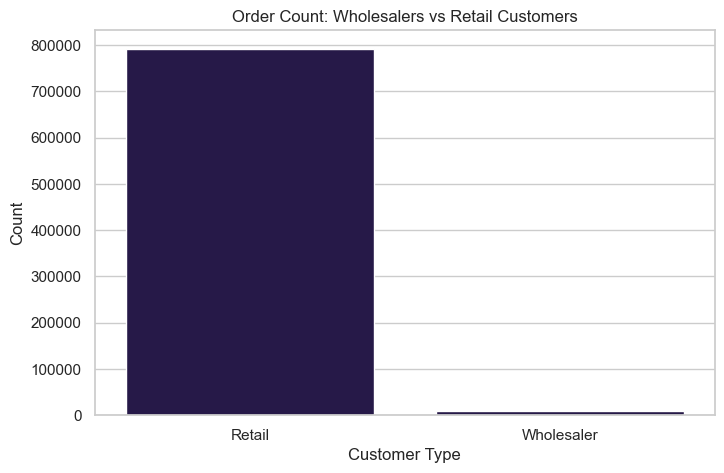

In [ ]:
# =============================
# Phase 2: Exploratory Data Analysis (EDA)
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization style
sns.set_theme(style="whitegrid", palette="magma")

# 1. Load Cleaned Dataset
df = pd.read_csv("online_retail_cleaned.csv")

# # 2. Sales Performance & Seasonality

# # Monthly revenue trends
# monthly_sales = df.groupby(["Year", "Month"])["TotalPrice"].sum().reset_index()
# monthly_sales["YearMonth"] = monthly_sales["Year"].astype(str) + "-" + monthly_sales["Month"].astype(str)

# plt.figure(figsize=(12,6))
# sns.lineplot(data=monthly_sales, x="YearMonth", y="TotalPrice", marker="o")
# plt.xticks(rotation=45)
# plt.title("Monthly Sales Revenue")
# plt.xlabel("Year-Month")
# plt.ylabel("Revenue")
# plt.show()

# Day of week sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Weekday'] = df['InvoiceDate'].dt.day_name()  
weekday_sales = df.groupby('Weekday')['TotalPrice'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(10,5))
weekday_sales.plot(kind='bar')
plt.title("Revenue by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.show()

# Hourly sales
plt.figure(figsize=(8,5))
sns.barplot(x="Hour", y="TotalPrice", data=df, estimator=sum)
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.show()

# 3. Product Portfolio Analysis

# Top 10 products by revenue
top_products_revenue = df.groupby("Description")["TotalPrice"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# Top 10 products by quantity
top_products_quantity = df.groupby("Description")["Quantity"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Quantity")
plt.ylabel("Product")
plt.show()

# 4. Geographic Footprint

# ---- Create Revenue column ----
df["Revenue"] = df["Quantity"] * df["Price"]

# ---- Group by Country and sum revenue ----
country_sales = df.groupby("Country", as_index=False)["Revenue"].sum()

# Top 10 countries by revenue
country_sales = df.groupby("Country")["TotalPrice"].sum().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()

# UK vs International sales
uk_sales = df[df["Country"]=="United Kingdom"]["TotalPrice"].sum()
intl_sales = df[df["Country"]!="United Kingdom"]["TotalPrice"].sum()

plt.figure(figsize=(6,6))
plt.pie([uk_sales, intl_sales], labels=["UK", "International"], autopct="%.1f%%", startangle=90)
plt.title("UK vs International Sales Share")
plt.show()


# 5. Customer Segmentation (RFM)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalPrice": "sum"
}).rename(columns={"InvoiceDate":"Recency","Invoice":"Frequency","TotalPrice":"Monetary"})

# RFM distributions
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.show()

# 6. Wholesale vs Retail Analysis

# Define customer type
df["CustomerType"] = np.where(df["Quantity"]>100, "Wholesaler", "Retail")

# Average order value comparison
plt.figure(figsize=(8,5))
sns.barplot(x="CustomerType", y="TotalPrice", data=df, estimator=np.mean)
plt.title("Average Order Value: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Average Order Value")
plt.show()

# Order count comparison
plt.figure(figsize=(8,5))
sns.countplot(x="CustomerType", data=df)
plt.title("Order Count: Wholesalers vs Retail Customers")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.show()


# API URL for GBP conversion
url = "https://open.er-api.com/v6/latest/GBP"

# Fetch exchange rates
response = requests.get(url)
data = response.json()

print(data)

# Extract rates
usd_rate = data['rates']['USD']
eur_rate = data['rates']['EUR']

print("1 GBP = ", usd_rate, "USD")
print("1 GBP = ", eur_rate, "EUR")

# Select top 100 transactions by TotalPrice
top100 = df.nlargest(100, 'TotalPrice').copy()

top100.head()

# Add converted columns
top100['TotalPrice_USD'] = top100['TotalPrice'] * usd_rate
top100['TotalPrice_EUR'] = top100['TotalPrice'] * eur_rate

top100[['Invoice', 'StockCode', 'Description', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']].head(10)


In [1]:
import requests
import pandas as pd

# Load dataset
df = pd.read_csv("online_retail_cleaned.csv")

# API URL for GBP conversion
url = "https://open.er-api.com/v6/latest/GBP"

# Fetch exchange rates
response = requests.get(url)
data = response.json()

print(data)

# Extract rates
usd_rate = data['rates']['USD']
eur_rate = data['rates']['EUR']

print("1 GBP = ", usd_rate, "USD")
print("1 GBP = ", eur_rate, "EUR")

# Select top 100 transactions by TotalPrice
top100 = df.nlargest(100, 'TotalPrice').copy()

top100.head()

# Add converted columns
top100['TotalPrice_USD'] = top100['TotalPrice'] * usd_rate
top100['TotalPrice_EUR'] = top100['TotalPrice'] * eur_rate

top100[['Invoice', 'StockCode', 'Description', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']].head(10)


{'result': 'success', 'provider': 'https://www.exchangerate-api.com', 'documentation': 'https://www.exchangerate-api.com/docs/free', 'terms_of_use': 'https://www.exchangerate-api.com/terms', 'time_last_update_unix': 1755648151, 'time_last_update_utc': 'Wed, 20 Aug 2025 00:02:31 +0000', 'time_next_update_unix': 1755735021, 'time_next_update_utc': 'Thu, 21 Aug 2025 00:10:21 +0000', 'time_eol_unix': 0, 'base_code': 'GBP', 'rates': {'GBP': 1, 'AED': 4.95632, 'AFN': 93.479817, 'ALL': 112.556701, 'AMD': 517.99211, 'ANG': 2.415742, 'AOA': 1259.653568, 'ARS': 1744.098354, 'AUD': 2.087311, 'AWG': 2.415742, 'AZN': 2.297761, 'BAM': 2.264877, 'BBD': 2.699153, 'BDT': 163.975203, 'BGN': 2.264748, 'BHD': 0.507441, 'BIF': 4042.72549, 'BMD': 1.349577, 'BND': 1.733747, 'BOB': 9.354743, 'BRL': 7.367791, 'BSD': 1.349577, 'BTN': 117.581602, 'BWP': 18.666768, 'BYN': 4.32187, 'BZD': 2.699153, 'CAD': 1.86932, 'CDF': 3927.219048, 'CHF': 1.08921, 'CLP': 1303.01552, 'CNY': 9.69852, 'COP': 5427.165418, 'CRC': 682

,Invoice,StockCode,Description,TotalPrice,TotalPrice_USD,TotalPrice_EUR
802201,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60,227362.865829,195090.155374
443303,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,77183.60,104165.288521,89379.689370
561096,556444,22502,PICNIC BASKET WICKER 60 PIECES,38970.00,52593.054660,45127.805580
337147,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,15818.40,21348.164635,18317.928658
171916,511465,15044A,PINK PAPER PARASOL,8925.00,12044.983650,10335.274950
654030,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,7144.72,9642.356928,8273.685786
438928,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,6539.40,8825.430373,7572.716752
515499,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,6539.40,8825.430373,7572.716752
294141,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,5179.20,6989.734378,5997.586109
713175,573003,23084,RABBIT NIGHT LIGHT,4992.00,6737.093376,5780.805888


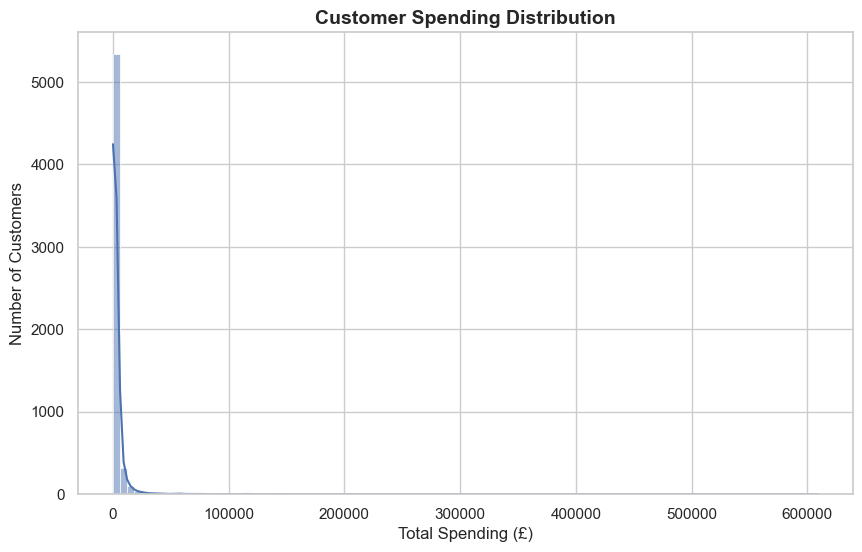

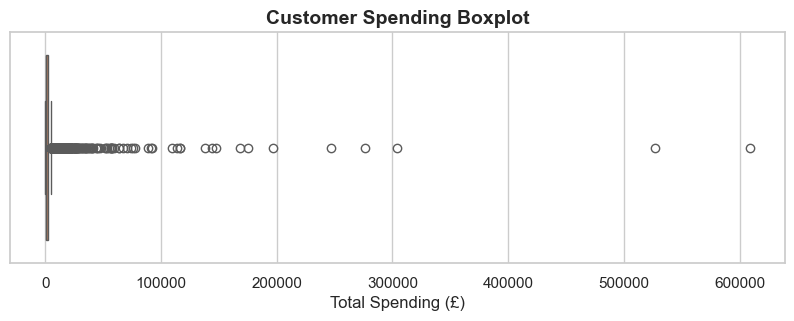

CustomerType
Retail        5266
Wholesaler     586
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

#load the dataset
df = pd.read_csv('online_retail_cleaned.csv')  

# Group data by customer and calculate total spending
customer_spending = df.groupby('Customer ID')['TotalPrice'].sum().reset_index()

# Rename column for clarity
customer_spending.rename(columns={'TotalPrice': 'TotalSpending'}, inplace=True)

# Quick check
customer_spending.head()

# Use a clean style
sns.set_style("whitegrid")

# Histogram
plt.figure(figsize=(10,6))
sns.histplot(customer_spending['TotalSpending'], bins=100, kde=True, color="#4C72B0")
plt.title("Customer Spending Distribution", fontsize=14, weight='bold')
plt.xlabel("Total Spending (£)")
plt.ylabel("Number of Customers")
plt.show()

# Boxplot
plt.figure(figsize=(10,3))
sns.boxplot(x=customer_spending['TotalSpending'], color="#DD8452")
plt.title("Customer Spending Boxplot", fontsize=14, weight='bold')
plt.xlabel("Total Spending (£)")
plt.show()

# Find threshold for top 10% spenders
threshold = customer_spending['TotalSpending'].quantile(0.90)

# Add a customer type column
customer_spending['CustomerType'] = customer_spending['TotalSpending'].apply(
    lambda x: 'Wholesaler' if x >= threshold else 'Retail'
)

# Count how many in each group
customer_spending['CustomerType'].value_counts()
